## Setting

### Optional

In [ ]:
!pip install xgboost lightgbm catboost -U

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 99.2/99.2 MB 9.3 MB/s eta 0:00:00


### Required

In [2]:
from train_tuning import Model
from evaluation import show_confusion_matrix, show_roc_curve, show_pr_curve, show_prediction_score

is_binary = True

In [1]:
model_type = "svm"
param_grid = {
    "kernel": ["linear", "rbf", "sigmoid"],
    "C": [0.1, 1, 10, 100, 1000],
    "gamma": [1, 0.1, 0.01, 0.001, 0.0001]
}
selected_features = ['mean_iat', 'std_iat', 'median_iat', 'q25_iat', 'q75_iat',
                     'ratio_out', 'switch_count', 'duration', 'n_packets', 'burst_count',
                     'burst_mean', 'burst_std', 'burst_max', 'burst_ratio_in'] # fixed

## Loading Data

In [11]:
import pickle
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler

use_original_data = False

# Load the pickle file
print("Loading datafile...")
with open(f"open_train_33.pkl", "rb") as f:
    train = pickle.load(f)
    X_train = pd.DataFrame(train["X"])
    X_train.columns = train["feature_names"]
    y_train = train["y_binary"]
    y_train = np.where(y_train == -1, 0, y_train)

with open(f"open_val_33.pkl", "rb") as f:
    val = pickle.load(f)
    X_val = pd.DataFrame(val["X"])
    X_val.columns = val["feature_names"]
    y_val = val["y_binary"]
    y_val = np.where(y_val == -1, 0, y_val)

if use_original_data:
    X_train = train["scaler"].inverse_transform(train['X'])
    X_train = pd.DataFrame(X_train)
    X_train.columns = train['feature_names']
    
    X_val = val["scaler"].inverse_transform(val['X'])
    X_val = pd.DataFrame(X_val)
    X_val.columns = val['feature_names']

print("Loading complete.")
print("Training data size:\t", len(X_train))
print("Validation data size:\t", len(X_val))

Loading datafile...
Loading complete.
Training data size:	 20300
Validation data size:	 4350


In [13]:
train

{'X': array([[-0.22686481, -0.22577087, -0.01340564, ...,  0.96712592,
          0.79852397,  0.82487355],
        [-0.24460966,  0.00875964, -0.01340564, ...,  0.06471017,
          0.79852397,  0.82487355],
        [ 1.48336257,  0.55889839, -0.01340564, ...,  0.36551542,
          1.35565988,  1.34944776],
        ...,
        [-0.28393383, -0.29332149, -0.01340564, ...,  0.66632067,
         -1.7085876 , -0.22427485],
        [-0.30575644, -0.4312636 , -0.01340564, ...,  0.36551542,
          0.12996089,  0.30029935],
        [-0.24230126, -0.23241517, -0.01340564, ...,  0.36551542,
          0.4128145 , -0.22427485]]),
 'y_true': array([93, 13, 24, ..., -1, -1, -1]),
 'y_binary': array([ 1,  1,  1, ..., -1, -1, -1]),
 'feature_names': ['mean_iat',
  'std_iat',
  'median_iat',
  'q25_iat',
  'q75_iat',
  'ratio_out',
  'switch_count',
  'duration',
  'n_packets',
  'burst_count',
  'burst_mean',
  'burst_std',
  'burst_max',
  'burst_ratio_in',
  'num_in',
  'num_out',
  'frac_in',

In [ ]:
# feature selection
def feature_selection(X, selected_features):
  return X[selected_features]

X_train = feature_selection(X_train, selected_features)
X_val = feature_selection(X_val, selected_features)

## Model

### Base Model Training

In [4]:
model = Model(is_binary=is_binary)
# change the model type and parameters accordingly
model.create_model(model_type, kernel = "rbf")
print(model.hparams)
model.fit(X_train, y_train)

{'C': 1.0, 'kernel': 'rbf', 'gamma': 'scale'}


In [5]:
y_test_pred = model.predict(X_val)
y_test_pred

array([1, 1, 1, ..., 0, 0, 0])

In [14]:
type(y_test_pred)

numpy.ndarray

In [6]:
model.score(X_val, y_val)

0.8889655172413793

In [7]:
_ = model.k_fold_cv(X_train, y_train, k = 5)

5-fold Cross Validation Scores:	[0.88399015 0.89162562 0.88423645 0.88793103 0.88866995]
5-fold Cross Validation Average Score:	0.8872906403940887


### Feature Evaluation

In [ ]:
model.get_feature_importances()

### Hyperparameter Tuning

In [8]:
# define parameter search space
bst = model.grid_search(X_train, y_train, param_grid)

Fitting 5 folds for each of 75 candidates, totalling 375 fits
[CV 1/5] END .....C=0.1, gamma=1, kernel=linear;, score=0.822 total time=  16.0s
[CV 2/5] END .....C=0.1, gamma=1, kernel=linear;, score=0.824 total time=  16.6s
[CV 3/5] END .....C=0.1, gamma=1, kernel=linear;, score=0.835 total time=  16.2s
[CV 4/5] END .....C=0.1, gamma=1, kernel=linear;, score=0.827 total time=  15.6s
[CV 5/5] END .....C=0.1, gamma=1, kernel=linear;, score=0.833 total time=  14.1s
[CV 1/5] END ........C=0.1, gamma=1, kernel=rbf;, score=0.672 total time=  44.5s
[CV 2/5] END ........C=0.1, gamma=1, kernel=rbf;, score=0.672 total time=  44.9s
[CV 3/5] END ........C=0.1, gamma=1, kernel=rbf;, score=0.672 total time=  44.0s
[CV 4/5] END ........C=0.1, gamma=1, kernel=rbf;, score=0.675 total time=  44.1s
[CV 5/5] END ........C=0.1, gamma=1, kernel=rbf;, score=0.672 total time=  44.0s
[CV 1/5] END ....C=0.1, gamma=1, kernel=sigmoid;, score=0.551 total time=  25.3s
[CV 2/5] END ....C=0.1, gamma=1, kernel=sigmoid

In [9]:
best_model = Model(is_binary)
best_model.create_model("svm", **bst.best_params_)
best_model.fit(X_train, y_train)
best_model.score(X_val, y_val)

0.9096551724137931

In [21]:
bst.best_params_

{'C': 10, 'gamma': 0.1, 'kernel': 'rbf'}

In [12]:
best_model.k_fold_cv(X_val, y_val)

/opt/anaconda3/lib/python3.13/site-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/opt/anaconda3/lib/python3.13/site-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/opt/anaconda3/lib/python3.13/site-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


5-fold Cross Validation Scores:	[0.83103448 0.7954023  0.82873563 0.8091954  0.79770115]
5-fold Cross Validation Average Score:	0.8124137931034483


/opt/anaconda3/lib/python3.13/site-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/opt/anaconda3/lib/python3.13/site-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


array([0.83103448, 0.7954023 , 0.82873563, 0.8091954 , 0.79770115])

### Evaluation

In [15]:
y = y_val
y_pred = bst.predict(X_val)
y_prob = bst.predict_proba(X_val)[:, 1]

1. Confusion Matrix

              precision    recall  f1-score   support

 unmonitored       0.88      0.86      0.87      1500
   monitored       0.93      0.94      0.93      2850

    accuracy                           0.91      4350
   macro avg       0.90      0.90      0.90      4350
weighted avg       0.91      0.91      0.91      4350



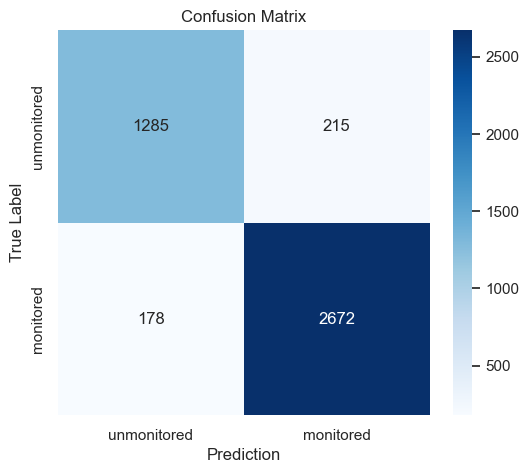

In [16]:
show_confusion_matrix(y, y_pred, model_type)

2. ROC Curve

- ROC AUC Score: 0.9656


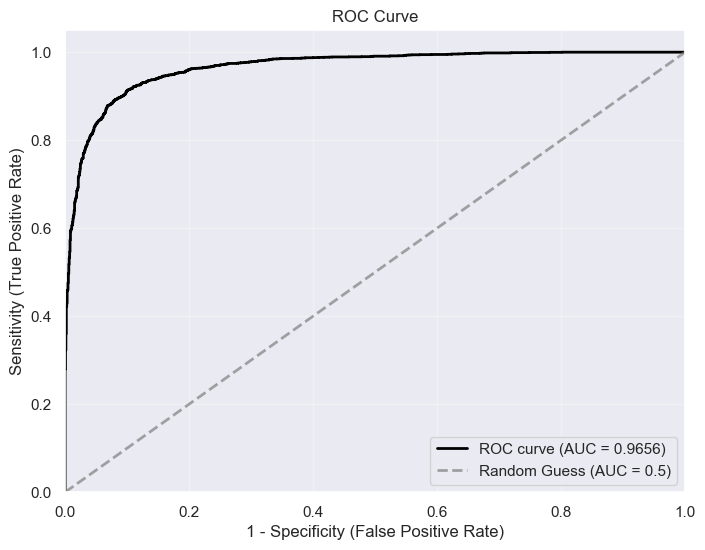

In [17]:
show_roc_curve(y, y_prob, model_type)

3. PR Curve

- Average Precision (AP) Score: 0.9813


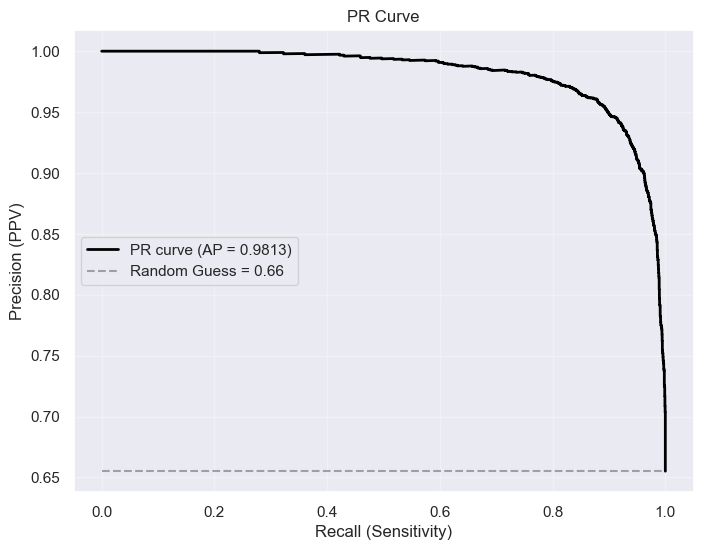

In [18]:
show_pr_curve(y, y_prob, model_type)

4. Prediction Score


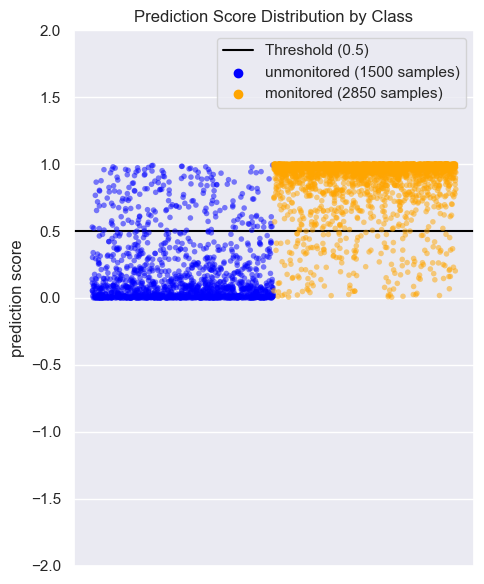

In [19]:
show_prediction_score(y, y_prob, model_type)

### Save Model

In [20]:
model.save_model(model=bst.best_estimator_, file_name=f"{bst.best_params_}")